
# Convolutional Neural Network

### The SVHN dataset (32-by-32 images)

---

The following notebook contains the source-code for my implementation of a small convolutional neural network on the 32-by-32 images SVHN dataset.

In [1]:
import os
import time
import math
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

print("Tensorflow version", tf.__version__)

Tensorflow version 1.15.0


In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


In [3]:
get_available_gpus()

['/device:GPU:0']

#### Loading the data

Let's load the greyscale images created in ``01-svhn-single-preprocessing.ipynb``

In [4]:
# Open the file as readonly
h5f = h5py.File('data/SVHN_single_grey_9.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_test2 = h5f['X_test2'][:]
y_test2 = h5f['y_test2'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)
print('Test set2', X_test2.shape, y_test2.shape)

Training set (548916, 32, 32, 1) (548916, 10)
Validation set (5490, 32, 32, 1) (5490, 10)
Test set (24288, 32, 32, 1) (24288, 10)
Test set2 (135, 32, 32, 1) (135, 10)


#### Data dimensions

In [5]:
# We know that SVHN images have 32 pixels in each dimension
img_size = X_train.shape[1]

# Greyscale images only have 1 color channel
num_channels = X_train.shape[-1]

# Number of classes, one class for each of 10 digits
num_classes = y_train.shape[1]

In [6]:
num_classes

10

#### Preprocessing

Let's apply mean subtraction and normalization to our images.

In [7]:
# Calculate the mean on the training data
train_mean = np.mean(X_train, axis=0)

# Calculate the std on the training data
train_std = np.std(X_train, axis=0)

#calculate the mean on the test2 data
#test2_mean = np.mean(X_test2, axis=0)

#calculate the std of test2 data
#test2_std = np.std(X_test2, axis=0)

# Subtract it equally from all splits
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std
X_test2 = (X_test2 - train_mean)  / train_std
X_val = (train_mean - X_val) / train_std

## Helper functions

Let's implement some helper functions to make our notebook easier to read and reduce code duplication.

### Helper function for plotting images

Here is a simple helper function that will help us plot ``nrows`` * ``ncols`` images with their true labels, and predicted labels - if passed to the function.

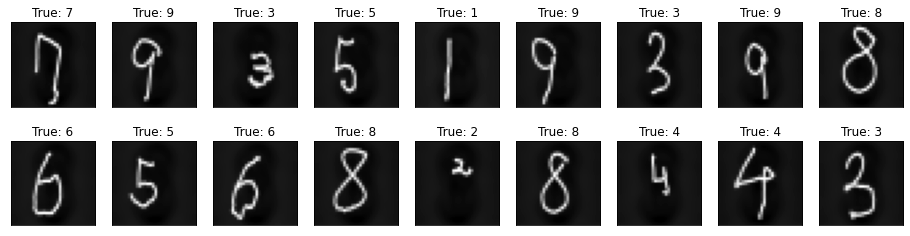

In [8]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
            #title = "True: {0}".format(cls_true[i])
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i]) 
            #title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])
        
        
# Plot 2 rows with 9 images each from the test2 set
plot_images(X_test2, 2, 9, y_test2);

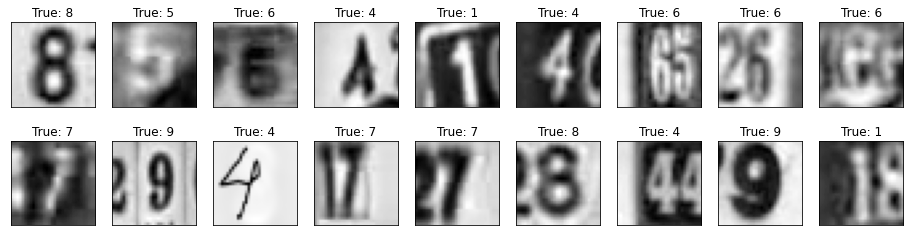

In [9]:
#plot 2 rows with 9 images each from the val set
plot_images(X_val, 2, 9, y_val);

### Helper functions for creating new variables

Functions for creating new [``TensorFlow Variables``](https://www.tensorflow.org/how_tos/variables/) in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [10]:
def conv_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name 
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

### Helper function for stacking CONV-RELU layers followed by an optional POOL layer

This function creates a new convolutional layer in the computational graph for TensorFlow. The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point it is common to transition to fully connected layers.

In other words, the most common ConvNet archiecture follows the pattern:

```INPUT > [[CONV -> RELU]*N -> POOL?]M -> [FC -> RELU]*K -> FC```

The following helper function simplifies the creation of this pattern

In [11]:
def conv_layer(input,               # The previous layer
                layer_name,         # Layer name
                num_input_channels, # Num. channels in prev. layer
                filter_size,        # Width and height of each filter
                num_filters,        # Number of filters
                pooling=True):      # Use 2x2 max-pooling

    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new filters with the given shape
    weights = conv_weight_variable(layer_name, shape=shape)
    
    # Create new biases, one for each filter
    biases = bias_variable(shape=[num_filters])

    # Create the TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME') # with zero padding

    # Add the biases to the results of the convolution
    layer += biases
    
    # Rectified Linear Unit (RELU)
    layer = tf.nn.relu(layer)

    # Down-sample the image resolution?
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Return the resulting layer and the filter-weights
    return layer, weights

### Helper function for reshaping the CONV layers to FC layers

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer. E.g., if the input layer has the shape (?, 8, 8, 32) the flattened layer will have the shape (?, 8 x 8 x 32) or (?, 2048).

In [12]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features

### Helper function for stacking FC-RELU layers

This function creates a new fully-connected layer in the computational graph for TensorFlow. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Their activations can hence be computed with a matrix multiplication followed by a bias offset.

As mentioned in previous section most ConvNet architectures follows the following pattern:

```INPUT > [[CONV -> RELU]*N -> POOL?]M -> [FC -> RELU]*K -> FC```

The following helper function will simplify the process of stacking the last layers of the model.

In [13]:
def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

## Tensorflow Model

The configuration of the Convolutional Neural Network and data dimensions are defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

Let's build our tensorflow graph step-by-step!

In [14]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 256            # Number of neurons in fully-connected layer.

### Placeholder Variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix.

In [15]:
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x.

In [16]:
y_true = tf.placeholder(tf.int64, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)
#y_true_cls = y_true

To reduce overfitting, we will apply dropout after the pooling layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. 

In [17]:
keep_prob = tf.placeholder(tf.float32)

### ConvNet Architecture

Let's implement the following ConvNet architecture based on the layer patterns proposed in the [``CS231n notes``](http://cs231n.github.io/convolutional-networks/#fc):

``` INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] -> DROPOUT -> [FC -> RELU] -> FC ```

#### Convolutional Layer 1

Create the first convolutional layer. It takes x as input and creates num_filters1 different filters, each having width and height equal to filter_size1. 

In [18]:
conv_1, w_c1 = conv_layer(input=x,
                          layer_name="conv_1",
                          num_input_channels=num_channels,
                          filter_size=filter_size1,
                          num_filters=num_filters1, pooling=True)

conv_1

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



<tf.Tensor 'MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>

#### Convolutional Layer 2

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [19]:
conv_2, w_c2 = conv_layer(input=conv_1,
                          layer_name="conv_2",
                          num_input_channels=num_filters1,
                          filter_size=filter_size2,
                          num_filters=num_filters2,
                          pooling=True)

# Apply dropout after the pooling operation
dropout = tf.nn.dropout(conv_2, keep_prob)

dropout

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<tf.Tensor 'dropout/mul_1:0' shape=(?, 8, 8, 64) dtype=float32>

#### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [20]:
layer_flat, num_features = flatten_layer(dropout)

layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 4096) dtype=float32>

#### Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [21]:
fc_1 = fc_layer(input=layer_flat,
                layer_name="fc_1",
                num_inputs=num_features,
                num_outputs=fc_size,
                relu=True)

fc_1

<tf.Tensor 'Relu_2:0' shape=(?, 256) dtype=float32>

#### Fully-Connected Layer 2

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [22]:
fc_2 = fc_layer(input=fc_1,
                layer_name="fc_2",
                num_inputs=fc_size,
                num_outputs=num_classes,
                relu=False)

fc_2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

#### Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [23]:
y_pred = tf.nn.softmax(fc_2)

# The class-number is the index of the largest element.
y_pred_cls = tf.argmax(y_pred, axis=1)

y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

### Cost Function

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

In [24]:
# Calcualte the cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc_2, labels=y_true)
#cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)

# Take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In training deep networks, it is usually helpful to anneal the learning rate over time. There are three common types of implementing the learning rate decay. Here we will use **exponential decay** which has the mathematical form $\alpha = \alpha_0 / (1 + k_t)$ where $a_0, k$ are hyperparameters and $t$ is the iteration number. In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. For more information on optimization see [CS231n - Learning](http://cs231n.github.io/neural-networks-3/#ada).

In [25]:
# Global step is required to compute the decayed learning rate
global_step = tf.Variable(0)

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

# Construct a new Adam optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Evaluation Metric

To evaluate the performance of our Convolutional Network we calculate the average accuracy across all samples

In [26]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
correct_prediction

<tf.Tensor 'Equal:0' shape=(?,) dtype=bool>

In [28]:
accuracy

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

## Execution Phase

### Create TensorFlow Session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [29]:
session = tf.Session()

The variables for weights and biases must be initialized before we start optimizing them.

In [30]:
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Saver

In order to save the variables of the neural network, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. The saved files are often called checkpoints because they may be written at regular intervals during optimization.
This is the directory used for saving and retrieving the data.

In [45]:
saver = tf.train.Saver()

save_dir = 'checkpoints/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_single_greyscale_9')

#### Restoring a Previous Session

Re-load all the variables that were saved to file during previous optimization (if any).

In [32]:
#saver.restore(sess=session, save_path=save_path)

### Helper function for executing the learning process

There are 600,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer. Additionally we must select a keep probability for our dropout tensor. The value of p=0.5 is a reasonable default, but this can be tuned on validation data. 

Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well.

In [33]:
# Number of training samples in each iteration 
batch_size = 64

# Keep probability in dropout layer
dropout = 0.5

In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [34]:
total_iterations = 0

def optimize(num_iterations, display_step):
    
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for step in range(num_iterations):

        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size)]
        
        feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every display_step
        if step % display_step == 0:
            
            # Calculate the accuracy on the training-set.
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
            
            # Calculate the accuracy on the validation-set
            validation_acc = session.run(accuracy, {x: X_val, y_true: y_val, keep_prob: 1.0})
            print("Validation accuracy: %.4f" % validation_acc)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_diff = time.time() - start_time
    
    # Calculate the accuracy on the test-set
    test_accuracy = session.run(accuracy, {x: X_test2, y_true: y_test2, keep_prob: 1.0})
    
    print("Test accuracy: %.4f" % test_accuracy)
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

Let's run a few iterations and see if our model works.

In [35]:
optimize(num_iterations=5000, display_step=500)

Minibatch accuracy at step 0: 0.2344
Validation accuracy: 0.1102
Minibatch accuracy at step 500: 0.7969
Validation accuracy: 0.8160
Minibatch accuracy at step 1000: 0.9062
Validation accuracy: 0.8534
Minibatch accuracy at step 1500: 0.9688
Validation accuracy: 0.8701
Minibatch accuracy at step 2000: 0.9531
Validation accuracy: 0.8701
Minibatch accuracy at step 2500: 0.9219
Validation accuracy: 0.8812
Minibatch accuracy at step 3000: 0.9844
Validation accuracy: 0.8949
Minibatch accuracy at step 3500: 0.9844
Validation accuracy: 0.8934
Minibatch accuracy at step 4000: 0.9531
Validation accuracy: 0.8949
Minibatch accuracy at step 4500: 0.9844
Validation accuracy: 0.8947
Test accuracy: 0.8000
Time usage: 0:01:19


As we can see the permance slowly but surely increases, which is good! However, our model seems to overfit on the training set and not give us equally good scores on the validation and test set. Let's run an additional 50,000 iterations and see if we can further increase our models performance.

In [37]:
optimize(num_iterations=50000, display_step=1000)

Minibatch accuracy at step 0: 0.9688
Validation accuracy: 0.9146
Minibatch accuracy at step 1000: 0.9531
Validation accuracy: 0.9217
Minibatch accuracy at step 2000: 0.9531
Validation accuracy: 0.9151
Minibatch accuracy at step 3000: 1.0000
Validation accuracy: 0.9169
Minibatch accuracy at step 4000: 1.0000
Validation accuracy: 0.9211
Minibatch accuracy at step 5000: 0.9844
Validation accuracy: 0.9182
Minibatch accuracy at step 6000: 0.9688
Validation accuracy: 0.9230
Minibatch accuracy at step 7000: 0.9688
Validation accuracy: 0.9204
Minibatch accuracy at step 8000: 0.9844
Validation accuracy: 0.9224
Minibatch accuracy at step 9000: 0.9219
Validation accuracy: 0.9215
Minibatch accuracy at step 10000: 0.9844
Validation accuracy: 0.9244
Minibatch accuracy at step 11000: 0.9688
Validation accuracy: 0.9255
Minibatch accuracy at step 12000: 1.0000
Validation accuracy: 0.9230
Minibatch accuracy at step 13000: 0.9844
Validation accuracy: 0.9235
Minibatch accuracy at step 14000: 0.9688
Valida

 Let's save all variables of the TensorFlow graph to file.

In [46]:
saver.save(sess=session, save_path=save_path)

'checkpoints/svhn_single_greyscale_9'

### Model evaluation

Let's plot some of the mis-classified examples in our testset and a confusion matrix showing how well our model is able to predict the different digits.

In [47]:
# Generate predictions for the testset
test_pred = session.run(y_pred_cls, {x: X_test2, y_true: y_test2, keep_prob: 1.0})

In [74]:
(X_test2[0]-train_mean)/train_std

array([[[-2.1929033],
        [-2.1949558],
        [-2.18844  ],
        ...,
        [-2.173576 ],
        [-2.183717 ],
        [-2.184097 ]],

       [[-2.2031536],
        [-2.2058182],
        [-2.1976004],
        ...,
        [-2.1810718],
        [-2.194485 ],
        [-2.1956625]],

       [[-2.210477 ],
        [-2.2153988],
        [-2.205957 ],
        ...,
        [-2.1864338],
        [-2.2025833],
        [-2.2033522]],

       ...,

       [[-2.2113302],
        [-2.217582 ],
        [-2.2064939],
        ...,
        [-2.2273128],
        [-2.2446926],
        [-2.2424378]],

       [[-2.2064214],
        [-2.2108757],
        [-2.19964  ],
        ...,
        [-2.2150846],
        [-2.230868 ],
        [-2.230091 ]],

       [[-2.1958942],
        [-2.1986964],
        [-2.1883533],
        ...,
        [-2.1998043],
        [-2.2134693],
        [-2.213196 ]]], dtype=float32)

In [53]:
image= np.expand_dims(X_test2[0], axis=0)

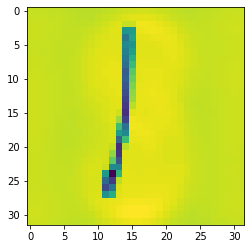

In [77]:
plt.imshow(image[0,:,:,0], cmap='binary')

In [56]:
image.shape

(1, 32, 32, 1)

In [64]:
label = np.expand_dims(y_test2[0], axis=0)

In [65]:
label.shape

(1, 10)

In [68]:
# Generate predictions for the testset
session.run(y_pred_cls, {x: image, keep_prob: 1.0})

array([1], dtype=int64)

Let's find some incorrectly classified examples and plot the true and predicted label values

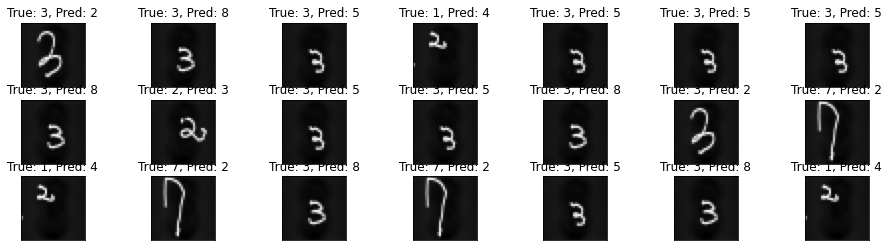

In [48]:
# Find the incorrectly classified examples
incorrect = test_pred != np.argmax(y_test2, axis=1)

# Select the incorrectly classified examples
images = X_test2[incorrect]
cls_true = y_test2[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 7, cls_true, cls_pred);

... and some correctly classified examples.

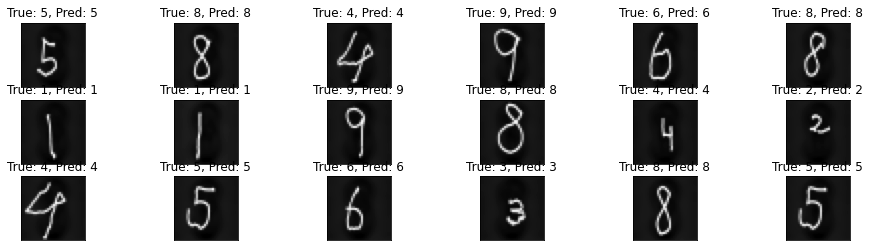

In [49]:
# Find the incorrectly classified examples
correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test2[correct]
cls_true = y_test2[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

We can also plot a [``confusion matrix``](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to show how well our model is able to predict the different class values

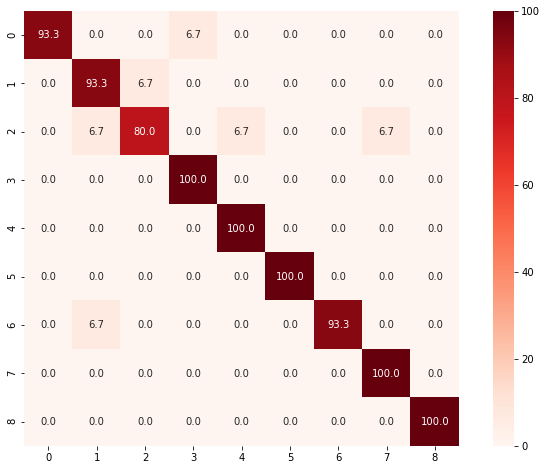

In [50]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test2, axis=1), y_pred=test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);